In [40]:
from PIL import Image, ImageDraw, ImageFont
import calmap
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import re
import plotly.express as px
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import nltk
import emoji
from nltk.corpus import stopwords
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
# Plot Style
plt.style.use('ggplot')

In [41]:
def startsWithDateAndTime(s):
    pattern = '^([0-9]+)(\/)([0-9]+)(\/)([0-9][0-9]), ([0-9]+):([0-9][0-9]) (am|pm) -'
    result = re.match(pattern, s)
    if result:
        return True
    return False

def FindAuthor(s):
    patterns = [
        '([\w]+):',                        
        '([\w]+[\s]+[\w]+):',              
        '([\w]+[\s]+[\w]+[\s]+[\w]+):',    
        '([\w]+)[\u263a-\U0001f999]+:', 
    ]
    pattern = '^' + '|'.join(patterns)
    result = re.match(pattern, s)
    if result:
        return True
    return False
  
def getDataPoint(line):   
    splitLine = line.split(' - ') 
    dateTime = splitLine[0]
    date, time = dateTime.split(', ') 
    message = ' '.join(splitLine[1:])
    if FindAuthor(message): 
        splitMessage = message.split(': ') 
        author = splitMessage[0] 
        message = ' '.join(splitMessage[1:])
    else:
        author = None
    return date, time, author, message

parsedData = [] 
conversationPath = 'WhatsApp Chat with Friends Toptops Forever.txt' 
with open(conversationPath, encoding="utf-8") as fp:
    fp.readline() 
    messageBuffer = [] 
    date, time, author = None, None, None
    while True:
        line = fp.readline() 
        if not line: 
            break
        line = line.strip() 
        if startsWithDateAndTime(line): 
            if len(messageBuffer) > 0: 
                parsedData.append([date, time, author, ' '.join(messageBuffer)]) 
            messageBuffer.clear() 
            date, time, author, message = getDataPoint(line) 
            messageBuffer.append(message) 
        else:
            messageBuffer.append(line)
df = pd.DataFrame(parsedData, columns=['Date', 'Time', 'Author', 'Message'])
df["Date"] = pd.to_datetime(df["Date"])

In [42]:
df['day'] = df['Date'].dt.strftime('%a')
df['month'] = df['Date'].dt.strftime('%b')
df['year'] = df['Date'].dt.year
df['date'] = df['Date'].apply(lambda x: x.date())
df = df.dropna()

In [43]:
df.Author.unique()

array(['Juan', 'Dani', 'Nanum', 'Mauro', 'Erick Hernandez', 'Irving',
       'Sweetheart❤️', 'Adonay'], dtype=object)

In [44]:

media_messages_df = df[df['Message'] == '<Media omitted>']
messages_df = df.drop(media_messages_df.index)
messages_df['Letter_Count'] = messages_df['Message'].apply(lambda s : len(s))
messages_df['Word_Count'] = messages_df['Message'].apply(lambda s : len(s.split(' ')))

# Stats

In [45]:
l = messages_df.Author.unique()
for i in range(len(l)):
  req_df= messages_df[messages_df["Author"] == l[i]]
  print(f'{l[i]} :')
  print('Messages: ', req_df.shape[0])
  words_per_message = (np.sum(req_df['Word_Count']))/req_df.shape[0]
  print('Words per message', words_per_message)
  media = media_messages_df[media_messages_df['Author'] == l[i]].shape[0]
  print('Media Messages: ', media) 
  print()

Juan :
Messages:  827
Words per message 3.2684401451027814
Media Messages:  355

Dani :
Messages:  1070
Words per message 4.376635514018692
Media Messages:  143

Nanum :
Messages:  918
Words per message 3.0806100217864922
Media Messages:  135

Erick Hernandez :
Messages:  3478
Words per message 3.045428407130535
Media Messages:  469

Mauro :
Messages:  2313
Words per message 2.669260700389105
Media Messages:  297

Irving :
Messages:  835
Words per message 3.5125748502994014
Media Messages:  278

Sweetheart❤️ :
Messages:  1050
Words per message 5.566666666666666
Media Messages:  222

Adonay :
Messages:  1388
Words per message 3.643371757925072
Media Messages:  67



### Who has sent the most messages

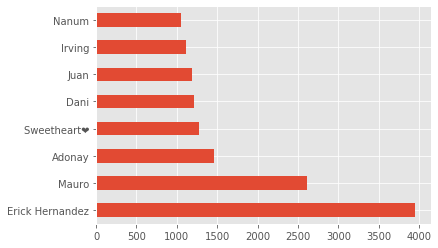

In [46]:
#Who has sent the most messages
author_value_counts = df['Author'].value_counts()
top_author_value_counts = author_value_counts.head(10)
top_author_value_counts.plot.barh()

Text(0.5, 1.0, 'The hour when the group is more active')

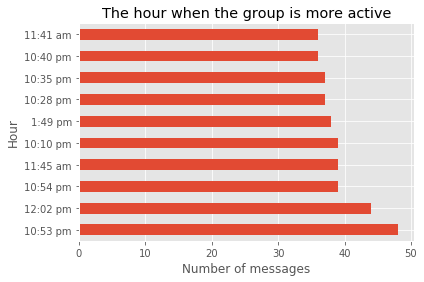

In [47]:
messages_df['Time'].value_counts().head(10).plot.barh() 
plt.xlabel('Number of messages')
plt.ylabel('Hour')
plt.title('The hour when the group is more active')

### Message frequency by day of the week

In [48]:
#Message frequency by day of the week
def dayofweek(i):
  l = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
  return l[i];
day_df=pd.DataFrame(messages_df["Message"])
day_df['day_of_date'] = messages_df['Date'].dt.weekday
day_df['day_of_date'] = day_df["day_of_date"].apply(dayofweek)
day_df["messagecount"] = 1
day = day_df.groupby("day_of_date").sum()
day.reset_index(inplace=True)

fig = px.line_polar(day, r='messagecount', theta='day_of_date', line_close=True)
fig.update_traces(fill='toself')
fig.update_layout(
  polar=dict(
    radialaxis=dict(
      visible=True,
      range=[0,1500]
    )),
  showlegend=False
)
fig.show()

In [49]:
df1 = df.copy()      
df1['message_count'] = [1] * df1.shape[0]      
df1.drop(columns='year', inplace=True)
df1 = df1.groupby('date').sum().reset_index()

# daily message frequency

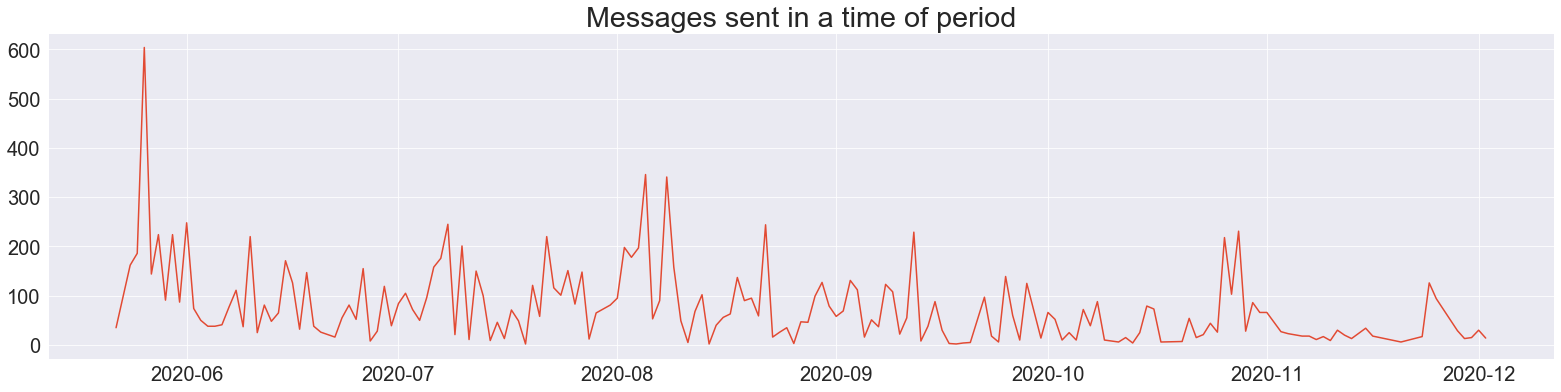

In [50]:
#daily message frequency
sns.set_style("darkgrid")

import matplotlib
matplotlib.rcParams['font.size'] = 20
matplotlib.rcParams['figure.figsize'] = (27, 6)     

# A basic plot
plt.plot(df1.date, df1.message_count)
plt.title('Messages sent in a time of period');

plt.savefig('msg_plots.svg', format = 'svg')

In [51]:
top10days = df1.sort_values(by="message_count", ascending=False).head(10)
top10days.reset_index(inplace=True)           
top10days.drop(columns="index", inplace=True) 

# The day when the group was most activitied

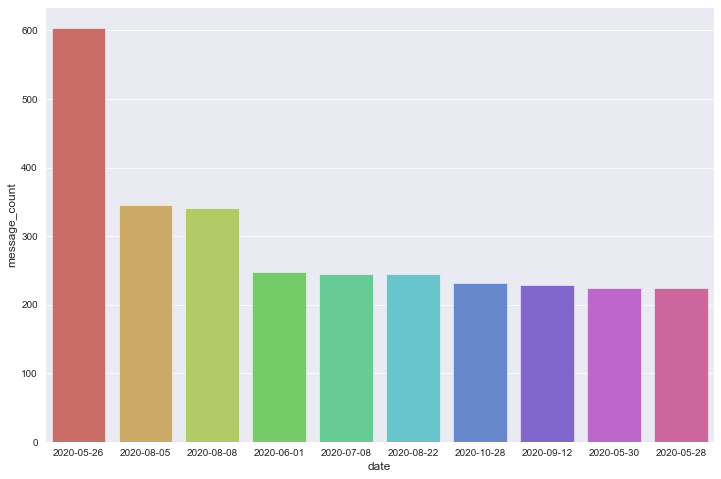

In [52]:
sns.set_style("darkgrid")
import matplotlib
matplotlib.rcParams['font.size'] = 10
matplotlib.rcParams['figure.figsize'] = (12, 8)
sns.barplot(top10days.date, top10days.message_count, palette="hls");
plt.savefig('top10_days.svg', format = 'svg')

In [53]:
df.Date = pd.DatetimeIndex(df.Time).time

In [54]:
total_messages = df.shape[0]
media_messages = df[df.Message == '<Media ommitted>'].shape[0]
urlPattern = r'(https?://\S+)'
links = df.Message.apply(lambda x: re.findall(urlPattern, x)).str.len().sum()

# Emoji analysis
# Most used emojis

In [55]:
#Emoji analysis
#Most used emojis
emojis=[]
for string in df.Message:
    my_str = str(string)
    for each in my_str:
        if each in emoji.UNICODE_EMOJI:
            emojis.append(each)
            

emoji_df = pd.DataFrame(emojis)
emoji_df = emoji_df[0].value_counts().head(10).reset_index()
emoji_df.columns = ['Emojis', 'Frenquency']
emoji_messages = emoji_df.Frenquency.sum()
emoji_df


Emojis  Frenquency
0      😂         256
1      🥺         251
2      ❤          71
3      🥴          62
4      👀          56
5      🤭          46
6      😍          43
7      ♥          43
8      🏻          39
9      👌          33

# most used emojis in chat by user (me)

In [56]:
#most used emojis in chat by user (me)
import plotly.express as px
fig = px.pie(emoji_df, values='Frenquency', names='Emojis',
             title='Emoji Distribution')
fig.update_traces(textposition='inside', textinfo='percent+label')
fig.show()

## Emoji frequency in chat

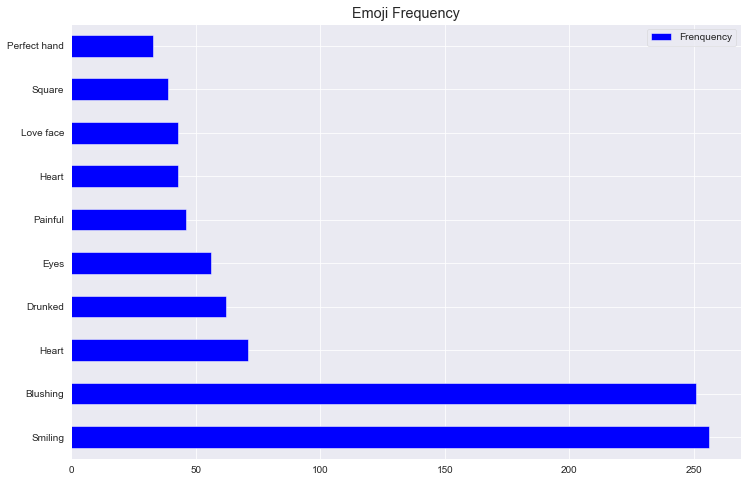

In [60]:
emoji_df.plot(kind='barh', color = 'blue', title='Emoji Frequency').set_yticklabels(
['Smiling', 'Blushing', 'Heart', 'Drunked', 'Eyes', 'Painful', 'Heart', 'Love face','Square', 'Perfect hand']);

In [61]:
print("All stats of Friends Toptops Forever")
print("Messages:", total_messages)
print("Media:", media_messages)
print("Emoji:", emoji_messages)

All stats of Friends Toptops Forever
Messages: 13845
Media: 0
Emoji: 900


In [62]:
media_messages_df = df[df['Message'] == '<Media omitted>']
messages_df = df.drop(media_messages_df.index)
messages_df['Letter_Count'] = messages_df['Message'].apply(lambda s : len(s))
messages_df['Word_Count'] = messages_df['Message'].apply(lambda s : len(s.split(' ')))


In [68]:
l = messages_df.Author.unique()

for i in range(len(l)):
  # Filtering out messages of particular user
  req_df= messages_df[messages_df["Author"] == l[i]]
  # req_df will contain messages of only one particular user
  print(f'Stats of {l[i]} -')
  # shape will print number of rows which indirectly means the number of messages
  print('Messages Sent', req_df.shape[0])
  #Word_Count contains of total words in one message. Sum of all words/ Total Messages will yield words per message
  words_per_message = (np.sum(req_df['Word_Count']))/req_df.shape[0]
  print('Words per message', words_per_message)
  #media conists of media messages
  media = media_messages_df[media_messages_df['Author'] == l[i]].shape[0]
  print('Media Messages Sent', media)
  # emojis conists of total emojis
  print('Emojis Sent', emoji_message) 
  print()

Stats of Juan -
Messages Sent 827
Words per message 3.2684401451027814
Media Messages Sent 355


NameError: name 'emoji_message' is not defined

# most used words in chat

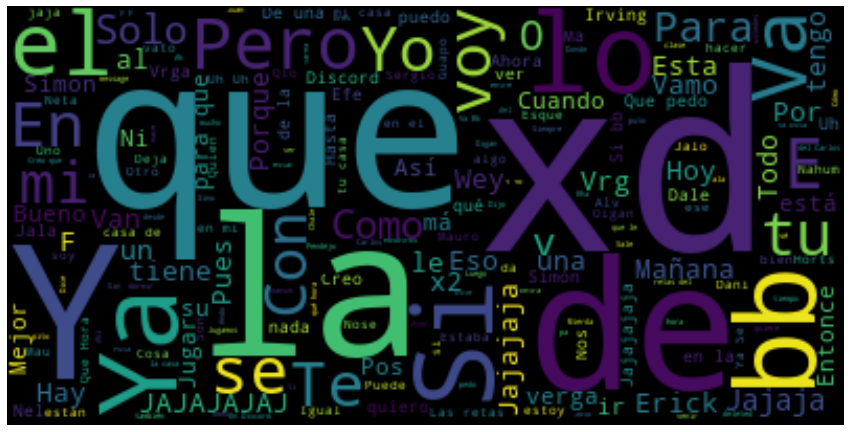

In [62]:
#most used words in chat
dfMessages = df.Author.value_counts().reset_index()
dfMessages.columns = ['Author', 'Messages']
dfNonMedia = df[df.Message.str.contains('<Media omitted>')]
df = df[~df.Message.str.contains('<Media omitted>')]
text = " ".join(review for review in df["Message"])

wordcloud = WordCloud(random_state=1,stopwords = STOPWORDS).generate(text)

bar,ax = plt.subplots(figsize=(15,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

# message frequency by time of the day

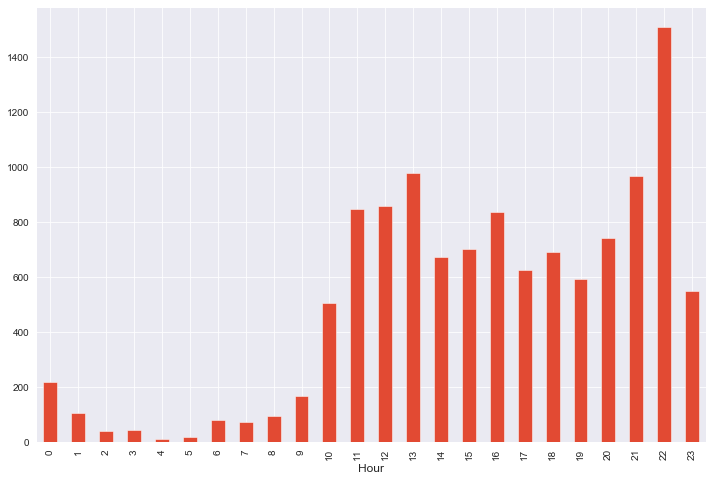

In [63]:
#message frequency by time of the day
df['Hour'] = df['Date'].apply(lambda x: x.hour)
df.groupby(['Hour']).size().sort_index().plot(x="Hour", kind='bar')

# most used words in chat by me

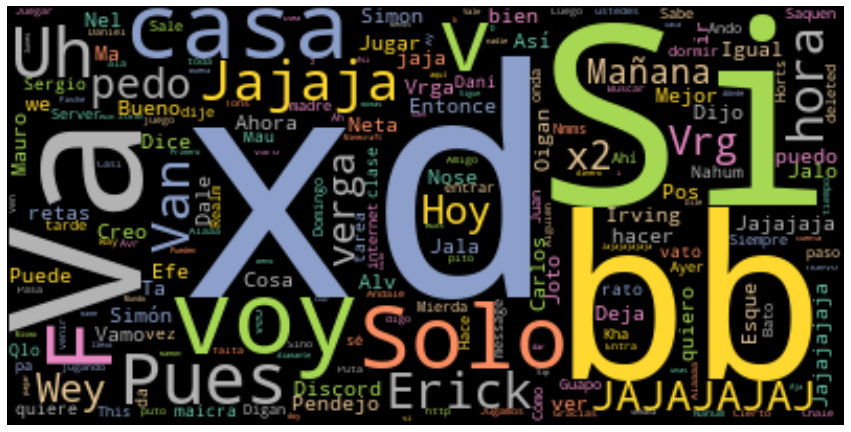

In [64]:
#most used words in chat by me
import nltk
from nltk.corpus import stopwords
stop_words_sp = set(stopwords.words('spanish'))
wordcloud = WordCloud(random_state=2,stopwords = stop_words_sp,colormap='Set2', collocations=False).generate(text)
bar,ax = plt.subplots(figsize=(15,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()


In [68]:
df2 = df.copy()    
df2 = df2[df2.Author != "group_notification"]
top10df = df2.groupby("Author")["Message"].count().sort_values(ascending=False)

# Final Data Frame
top10df = top10df.head(10).reset_index()
top10df

Author  Message
0  Erick Hernandez     3478
1            Mauro     2313
2           Adonay     1388
3             Dani     1070
4     Sweetheart❤️     1050
5            Nanum      918
6           Irving      835
7             Juan      828

## most used emojis in chat per user
## most used words in chat by user

In [73]:
import re
import pandas as pd
import matplotlib.pyplot as plt
import emoji

In [202]:
file = open(r'./WhatsApp Chat with Adonay (2).txt',mode='r',encoding="utf8")
data = file.read()
file.close()
data

"7/28/20, 00:36 - Erick Hernandez: Haber Cuando Cajillas :')\n7/28/20, 07:55 - Adonay: :( puedo los lunes por la tarde bb\n7/31/20, 16:19 - Erick Hernandez: Andale Vrga xd\n7/31/20, 16:20 - Adonay: No es mio men jajaja\n7/31/20, 16:20 - Adonay: Es de mi tio el panadero\n7/31/20, 16:38 - Erick Hernandez: <Media omitted>\n7/31/20, 18:05 - Adonay: Pues que te digo cate xd\n8/6/20, 16:38 - Erick Hernandez: Mmamamamamamama Ta Rica La Rola\n8/6/20, 17:16 - Adonay: Truena chingon como tus nalgas bb\n8/6/20, 17:16 - Erick Hernandez: Avr bb\n8/6/20, 17:16 - Erick Hernandez: Besame\n8/6/20, 17:19 - Adonay: El chulo sin h bb\n8/6/20, 17:19 - Adonay: asi\n8/6/20, 17:46 - Erick Hernandez: Ya bb, respetame\n8/6/20, 17:54 - Adonay: No quieres bb?\n8/8/20, 14:59 - Erick Hernandez: Respeta Bb\n8/8/20, 15:38 - Adonay: Jajajajaja nel bb\n8/8/20, 15:40 - Erick Hernandez: Dale Bb\n8/8/20, 15:40 - Erick Hernandez: Besame Bb\n8/9/20, 14:33 - Adonay: Bb\n8/9/20, 14:34 - Adonay: Fuiste bb?\n8/9/20, 16:41 - Eri

In [192]:
pattern = re.compile('\d+:\d+\s+-\s+([a-zA-Z0-9]+\s?[a-zA-Z0-9]+\s?[a-zA-Z0-9]+\s?):\s+')
messengers = re.findall(pattern,data)

In [193]:
count_messages={}
for each in messengers:
    if each in count_messages.keys():
        count_messages[each]+=1
    else:
        count_messages[each]=1
count_messages

{'Erick Hernandez': 73, 'Adonay': 84}

In [194]:
messages_split = pattern.split(data)
messages_split[9:11]

['Adonay', 'Es de mi tio el panadero\n7/31/20, ']

In [195]:
sep_msgs=[]
for each in count_messages.keys():
    for msg in range(len(messages_split)):
        if each == messages_split[msg]:
            sep_msgs.append(messages_split[msg+1])   #obtaining the message mentioned after sender along with dates
print(len(sep_msgs))   
sep_msgs[7]

157


'Respeta Bb\n8/8/20, '

In [196]:
cleaned_sep_msg = []
for each in sep_msgs:
    if '\n0' in each:
        cleaned_sep_msg.append(each.split('\n0'))
    elif '\n1' in each:
        cleaned_sep_msg.append(each.split('\n1'))
    elif '\n2' in each:
        cleaned_sep_msg.append(each.split('\n2'))
    elif '\n3' in each:
        cleaned_sep_msg.append(each.split('\n3'))
my_msg = []
for each in cleaned_sep_msg:
    my_msg.append(each[0])
print(len(my_msg))
my_msg[1]

43


'El Segio'

In [197]:
for each in count_messages.keys():
    if messages_split[-2] == each:
        my_msg.insert(count_messages[each]-1,messages_split[-1])
len(my_msg)

44

In [198]:
who_sent_what = []
prev = 0
for each in count_messages.keys():
    num = count_messages[each]
    
    nex = num+prev
    messages = my_msg[prev:nex]
    who_sent_what.append(messages)
    prev = nex
who_sent_what
my_df=pd.DataFrame(who_sent_what)
my_df = my_df.transpose()
my_df.columns = [list(count_messages.keys())[0],list(count_messages.keys())[1]]

In [199]:
def extract_emojis(columnname):
    emojis=[]
    for string in my_df[columnname]:
        my_str = str(string)
        for each in my_str:
            if each in emoji.UNICODE_EMOJI:
                emojis.append(each)
    return emojis

In [200]:
#Pienso que es un error porque adonay no ha mandado emojis
emoji_dict={}
for keys in count_messages.keys():
    print(keys)
    emoji_dict[keys] = extract_emojis(keys)
    emoji_df = pd.DataFrame(emoji_dict[keys])
    print(emoji_df[0].value_counts()[:5])

Erick Hernandez
🥺    2
Name: 0, dtype: int64
Adonay


KeyError: 0